# ============================================================================
# 1. Load Libraries and Data
# ============================================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
# Load the dataset
df = pd.read_csv("C:\\Users\\hp\\Desktop\\Mini Project\\Project\\Data\\Dataset.csv")
print("Data shape:", df.shape)
print("Preview of data:\n", df.head())

Data shape: (6362620, 11)
Preview of data:
    step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


# ============================================================================
# 2. Preliminary Data Analysis
# ============================================================================

In [3]:
print("\nData Information:")
df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.0000

In [6]:
# Fraud and flagged fraud counts
print("\nFraud Statistics:")
print('Number of fraudulent transactions \t: {}'.format(df['isFraud'].sum()))
print('Number of non-fraudulent transactions \t: {}'.format(len(df[df['isFraud']==0])))
print('Number of transactions flagged as fraud \t: {}'.format(len(df[df['isFlaggedFraud']==1])))
print('Number of transactions flagged as non-fraud \t: {}'.format(len(df[df['isFlaggedFraud']==0])))


Fraud Statistics:
Number of fraudulent transactions 	: 8213
Number of non-fraudulent transactions 	: 6354407
Number of transactions flagged as fraud 	: 16
Number of transactions flagged as non-fraud 	: 6362604


In [7]:
# Fraud by transaction type
fraudby_type = df.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
flaggedFraudby_type = df[df['isFlaggedFraud'] == 1].groupby('type')['isFlaggedFraud'].count()
print("\nFraud per Transaction Type:\n", fraudby_type)
print("\nFlagged Fraud per Transaction Type:\n", flaggedFraudby_type)


Fraud per Transaction Type:
 isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097

Flagged Fraud per Transaction Type:
 type
TRANSFER    16
Name: isFlaggedFraud, dtype: int64


# ============================================================================
# 3. Data Preprocessing and Feature Engineering
# ============================================================================

In [8]:
# -- Fix Missing Data --
# For transactions with merchant destination accounts, set oldbalanceDest to NaN
df.loc[df['nameDest'].str.startswith('M'), 'oldbalanceDest'] = np.NaN
print("\nRows with merchant missing oldbalanceDest:", df['oldbalanceDest'].isnull().sum())


Rows with merchant missing oldbalanceDest: 2151495


In [9]:
# Interpolate missing values and assign 0 where interpolation fails
df = df.interpolate()
df.loc[df['oldbalanceDest'].isnull(), 'oldbalanceDest'] = 0

C:\Users\hp\AppData\Local\Temp\ipykernel_4544\4020637603.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


In [10]:
# For merchant transactions, update newbalanceDest = oldbalanceDest + amount
newbalanceDest = df.loc[df.nameDest.str.get(0) == 'M', 'oldbalanceDest'] + df.loc[df.nameDest.str.get(0) == 'M', 'amount']
df.loc[df['nameDest'].str.get(0) == 'M', 'newbalanceDest'] = newbalanceDest

In [11]:
# -- Drop Unnecessary Columns --
# Customer IDs are not needed for prediction
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [12]:
# -- Feature Engineering --
# Create new features based on balance differences
df['diffOrg']  = df['oldbalanceOrg']  - df['newbalanceOrig'] + df['amount']
df['diffDest'] = df['oldbalanceDest'] - df['newbalanceDest'] + df['amount']

# ============================================================================
# 4. Create Refined Dataset (df2)
# ============================================================================

In [13]:
# Focus on transaction types that contribute to fraud (CASH_OUT and TRANSFER)
df2 = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])].copy(deep=True)
df2['diffOrg']  = df2['oldbalanceOrg']  - df2['newbalanceOrig'] + df2['amount']
df2['diffDest'] = df2['oldbalanceDest'] - df2['newbalanceDest'] + df2['amount']

# ============================================================================
# 5. One-Hot Encoding for Categorical Variable 'type'
# ============================================================================

In [14]:
# This transformation is deterministic and does not induce leakage.
def one_hot_encode(df_in):
    df_encoded = pd.concat([df_in, pd.get_dummies(df_in['type'])], axis=1)
    df_encoded = df_encoded.drop('type', axis=1)
    return df_encoded

df_encoded  = one_hot_encode(df)
df2_encoded = one_hot_encode(df2)

In [15]:
# Separate target variable for both datasets
Y_full = df_encoded['isFraud']
X_full = df_encoded.drop('isFraud', axis=1)

Y_refined = df2_encoded['isFraud']
X_refined = df2_encoded.drop('isFraud', axis=1)

# ============================================================================
# 6. Train, Validation, and Test Split (Before Normalization & SMOTE)
# ============================================================================

In [16]:
from sklearn.model_selection import train_test_split

# For the full dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_full, Y_full, test_size=0.2, random_state=55, stratify=Y_full)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=55, stratify=y_temp)

In [17]:
# For the refined dataset (df2)
X2_train, X2_temp, y2_train, y2_temp = train_test_split(X_refined, Y_refined, test_size=0.2, random_state=55, stratify=Y_refined)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.5, random_state=55, stratify=y2_temp)

# ============================================================================
# 7. Normalization (Applied Post-Splitting)
# ============================================================================

In [18]:
from sklearn.preprocessing import StandardScaler

# Define columns that require a log transformation (a fixed, non-data-dependent transformation)
log_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'diffOrg', 'diffDest']

def apply_log_transform(df, columns):
    df_trans = df.copy()
    for col in columns:
        # Adding 10 to avoid log(0); this transformation is fixed.
        df_trans[col] = np.log(df_trans[col] + 10)
    return df_trans

In [19]:
# Apply log transformation to all splits for both datasets
X_train = apply_log_transform(X_train, log_cols)
X_val   = apply_log_transform(X_val, log_cols)
X_test  = apply_log_transform(X_test, log_cols)

X2_train = apply_log_transform(X2_train, log_cols)
X2_val   = apply_log_transform(X2_val, log_cols)
X2_test  = apply_log_transform(X2_test, log_cols)

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# For the 'step' column, we perform standard scaling based solely on the training data.
scaler = StandardScaler()
X_train['step'] = scaler.fit_transform(X_train[['step']])
X_val['step']   = scaler.transform(X_val[['step']])
X_test['step']  = scaler.transform(X_test[['step']])

scaler2 = StandardScaler()
X2_train['step'] = scaler2.fit_transform(X2_train[['step']])
X2_val['step']   = scaler2.transform(X2_val[['step']])
X2_test['step']  = scaler2.transform(X2_test[['step']])

# ============================================================================
# 8. SMOTE Oversampling (Only on Training Data)
# ============================================================================

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [22]:
# Before applying SMOTE, ensure that the training data has no missing values
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X2_train = pd.DataFrame(imputer.fit_transform(X2_train), columns=X2_train.columns)

In [23]:
# Now apply SMOTE to balance the training data
smote = SMOTE(random_state=55)
X_train, y_train = smote.fit_resample(X_train, y_train)
X2_train, y2_train = smote.fit_resample(X2_train, y2_train)

print("\nAfter SMOTE, full dataset training size:", X_train.shape)
print("After SMOTE, refined dataset training size:", X2_train.shape)


After SMOTE, full dataset training size: (10167052, 14)
After SMOTE, refined dataset training size: (4419514, 11)


# ============================================================================
# 9. Model Training: XGBoost Classifiers
# ============================================================================

In [24]:
from xgboost import XGBClassifier
import gc

In [25]:
# Train two models: one on the full dataset and one on the refined dataset
model = XGBClassifier(tree_method="hist", random_state=55)
model2 = XGBClassifier(tree_method="hist", random_state=55)

model.fit(X_train, y_train)
model2.fit(X2_train, y2_train)
gc.collect()

59

In [26]:
# Define an evaluation function for model performance
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

def evaluate(trained_model, X_data, y_data):
    y_pred = trained_model.predict(X_data)
    f1 = f1_score(y_data, y_pred)
    acc = accuracy_score(y_data, y_pred)
    roc_auc = roc_auc_score(y_data, y_pred)
    report = classification_report(y_data, y_pred)
    return {'f1_score': f1, 'accuracy': acc, 'roc_auc_score': roc_auc}, report

In [27]:
# Evaluate on training and validation sets for both models
eval_train, report_train = evaluate(model, X_train, y_train)
eval_val, report_val = evaluate(model, X_val, y_val)

eval2_train, report2_train = evaluate(model2, X2_train, y2_train)
eval2_val, report2_val = evaluate(model2, X2_val, y2_val)

In [28]:
import pprint
pprint._sorted = lambda x: x

print("\n=== Full Dataset Model Evaluation ===")
print("Training Data Metrics:")
pprint.pprint(eval_train)
print(report_train)

print("\nValidation Data Metrics:")
pprint.pprint(eval_val)
print(report_val)

print("\n=== Refined Dataset Model Evaluation ===")
print("Training Data Metrics:")
pprint.pprint(eval2_train)
print(report2_train)

print("\nValidation Data Metrics:")
pprint.pprint(eval2_val)
print(report2_val)


=== Full Dataset Model Evaluation ===
Training Data Metrics:
{'accuracy': 0.9989401057455003,
 'f1_score': 0.9989409170070488,
 'roc_auc_score': 0.9989401057455002}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083526
           1       1.00      1.00      1.00   5083526

    accuracy                           1.00  10167052
   macro avg       1.00      1.00      1.00  10167052
weighted avg       1.00      1.00      1.00  10167052


Validation Data Metrics:
{'accuracy': 0.9981249862478035,
 'f1_score': 0.5764998225062122,
 'roc_auc_score': 0.993587242961294}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.41      0.99      0.58       821

    accuracy                           1.00    636262
   macro avg       0.70      0.99      0.79    636262
weighted avg       1.00      1.00      1.00    636262


=== Refined Dataset Model Evaluation ===
Training 

In [29]:
# Final evaluation on test sets
gc.collect()
eval_test, report_test = evaluate(model, X_test, y_test)
eval2_test, report2_test = evaluate(model2, X2_test, y2_test)

In [30]:
print("\nTest Data Metrics (Full Dataset):")
pprint.pprint(eval_test)
print(report_test)

print("\nTest Data Metrics (Refined Dataset):")
pprint.pprint(eval2_test)
print(report2_test)


Test Data Metrics (Full Dataset):
{'accuracy': 0.9981894251110391,
 'f1_score': 0.5870967741935483,
 'roc_auc_score': 0.997271084533873}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635440
           1       0.42      1.00      0.59       822

    accuracy                           1.00    636262
   macro avg       0.71      1.00      0.79    636262
weighted avg       1.00      1.00      1.00    636262


Test Data Metrics (Refined Dataset):
{'accuracy': 0.9967983078316928,
 'f1_score': 0.6470354158376442,
 'roc_auc_score': 0.9929362288248853}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    276219
           1       0.48      0.99      0.65       822

    accuracy                           1.00    277041
   macro avg       0.74      0.99      0.82    277041
weighted avg       1.00      1.00      1.00    277041



In [31]:
# Based on performance, we select 'model' (trained on the full dataset) as our best classifier.
best_model = model

# ============================================================================
# 10. Feature Importance Visualization with XGBoost
# ============================================================================

In [32]:
from xgboost import plot_importance

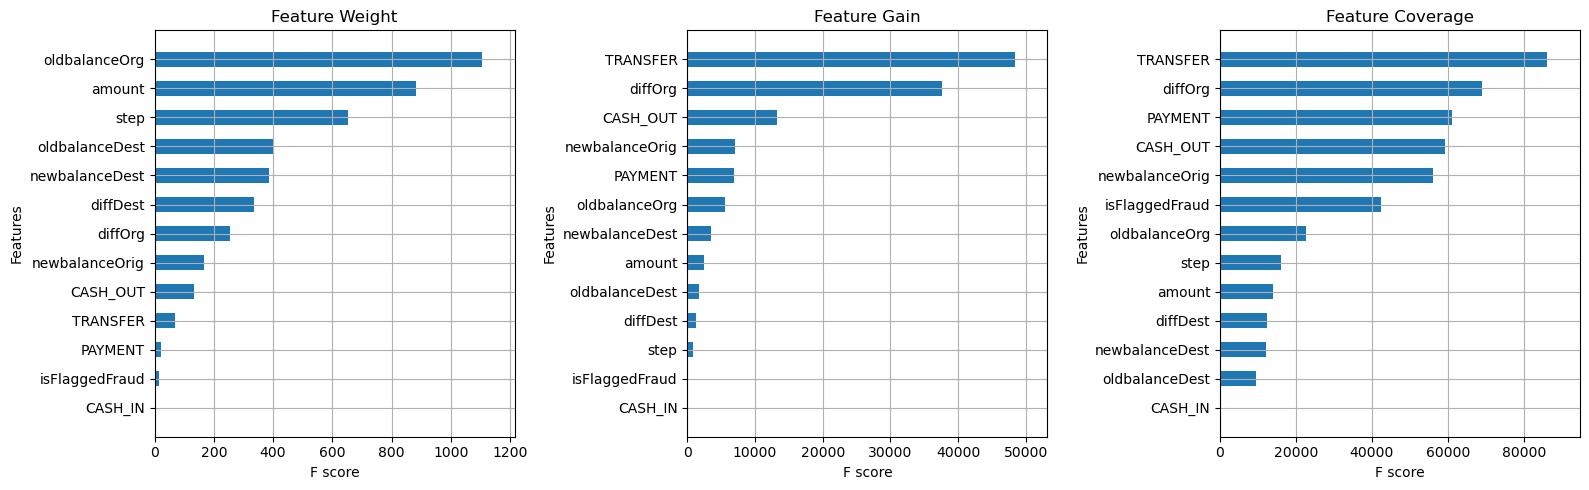

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
plot_importance(best_model, importance_type='weight', title='Feature Weight', show_values=False, height=0.5, ax=ax[0])
plot_importance(best_model, importance_type='gain', title='Feature Gain', show_values=False, height=0.5, ax=ax[1])
plot_importance(best_model, importance_type='cover', title='Feature Coverage', show_values=False, height=0.5, ax=ax[2])
plt.tight_layout()
plt.show()

# ============================================================================
# 11. Explainability with SHAP: Why Was a Transaction Flagged?
# ============================================================================

In [34]:
import shap

In [35]:
# Initialize SHAP explainer for the best model
explainer = shap.TreeExplainer(best_model)

In [36]:
# Compute SHAP values for a random sample (100 rows) from the test set
X_sample = X_test.sample(n=100, random_state=55)
shap_values = explainer.shap_values(X_sample)


Rendering SHAP summary plot for model explanation:


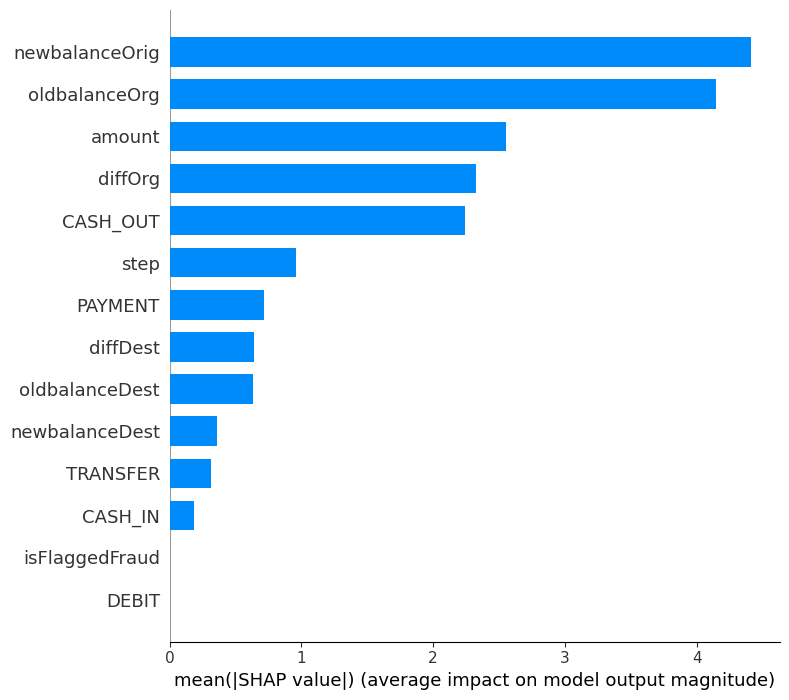

In [37]:
# Render the SHAP summary plot (bar plot format for corporate clarity)
shap.initjs()
print("\nRendering SHAP summary plot for model explanation:")
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=X_sample.columns)

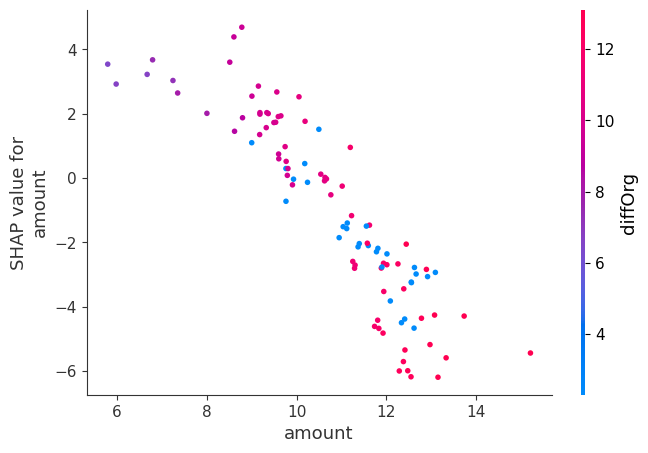

In [38]:
# Additionally, render a dependence plot for the 'amount' feature if it exists.
if 'amount' in X_sample.columns:
    shap.dependence_plot('amount', shap_values, X_sample)
else:
    print("Feature 'amount' is not available for SHAP dependence plot.")